Dataset Shape: (129898, 7)
First Few Rows:
    Sensor1_Temp  Sensor1_Pressure  Sensor1_Humidity  Sensor2_Temp  \
0         33.97          909.5364             78.81         33.96   
1         33.96          909.5364             78.81         33.95   
2         33.95          909.5324             78.99         33.94   
3         33.95          909.5289             79.12         33.94   
4         33.95          909.5289             79.18         33.94   

   Sensor2_Pressure  Sensor2_Humidity Label  
0          909.4451             87.90     N  
1          909.4553             87.90     N  
2          909.4709             87.99     N  
3          909.4604             88.01     N  
4          909.4604             88.01     N  
After Dropping NaN - Shape: (109971, 7)
Epoch 1/50
19/19 [==============================] - 5s 115ms/step - loss: 1.0281 - accuracy: 0.4130 - val_loss: 0.7212 - val_accuracy: 0.7347
Epoch 2/50
19/19 [==============================] - 2s 80ms/step - loss: 0.7906 - a

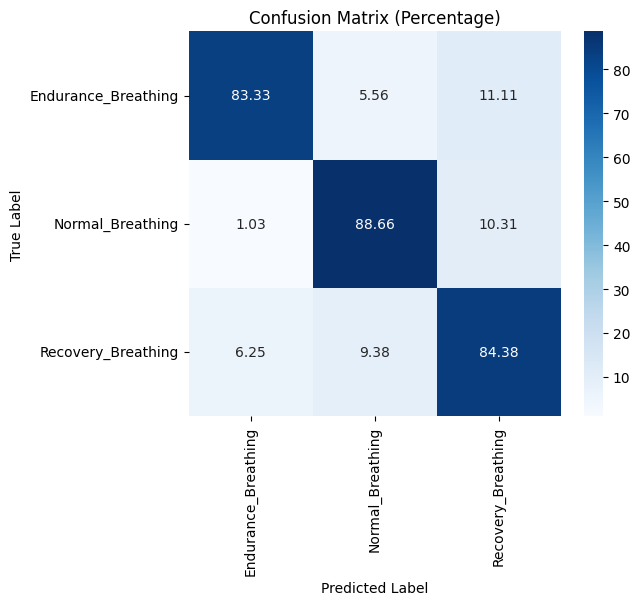

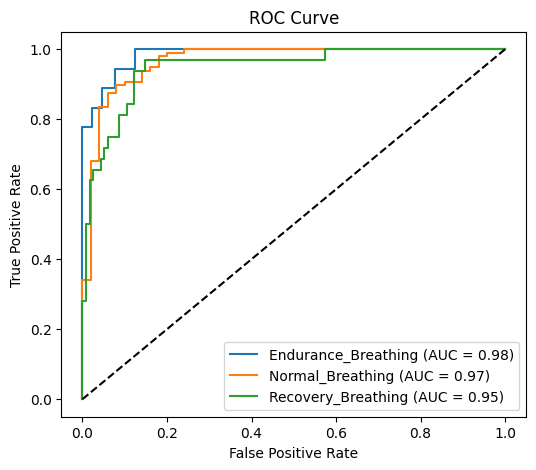

Model training completed and saved.


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_fscore_support
import joblib
from tensorflow.keras.callbacks import EarlyStopping

# Load dataset
file_path = "C:\\Users\\ADWIN ADI\\Downloads\\breathing.csv files\\MainData_NaN_Outliner_Removed (1).csv"
df = pd.read_csv(file_path)

# Print dataset info
print("Dataset Shape:", df.shape)
print("First Few Rows:\n", df.head())

# Drop NaN values
df.dropna(inplace=True)
print("After Dropping NaN - Shape:", df.shape)

# Ensure dataset is not empty after dropping NaN values
if df.empty:
    raise ValueError("Dataset is empty after dropping NaN values. Check the CSV file!")

# Select features (all columns except the last one) and target (last column)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
joblib.dump(label_encoder, "/mnt/data/label_encoder.pkl")

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.nan_to_num(X_scaled)
joblib.dump(scaler, "/mnt/data/scaler.pkl")

# Verify no NaN values exist
if np.isnan(X_scaled).any() or np.isnan(y_encoded).any():
    raise ValueError("NaN values detected in dataset after preprocessing!")

# Segment data into 10-second windows at 15 Hz (150 samples per segment)
segment_size = 150
num_segments = len(X_scaled) // segment_size
if num_segments == 0:
    raise ValueError(f"Not enough samples for segmentation! Required: {segment_size}, Found: {len(X_scaled)}")

X_segmented = np.array([X_scaled[i * segment_size:(i + 1) * segment_size] for i in range(num_segments)])

def majority_label(labels):
    return np.bincount(labels).argmax()

y_segmented = np.array([majority_label(y_encoded[i * segment_size:(i + 1) * segment_size]) for i in range(num_segments)])

# One-hot encode labels
ohe = OneHotEncoder(sparse_output=False)
y_segmented_ohe = ohe.fit_transform(y_segmented.reshape(-1, 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_segmented, y_segmented_ohe, test_size=0.2, random_state=42)

# Build SimpleRNN model
model = Sequential([
    SimpleRNN(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    SimpleRNN(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, callbacks=[early_stopping])

# Save trained model
model.save("/mnt/data/breathing_pattern_model.h5")

# Predict test labels
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Confusion matrix (percentage format)
cm = confusion_matrix(y_test_labels, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing'], 
            yticklabels=['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# ROC Curve
plt.figure(figsize=(6, 5))
class_labels = ['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing']

for i in range(y_train.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Performance Table
precision, recall, f1, _ = precision_recall_fscore_support(y_test_labels, y_pred, labels=[0, 1, 2])
accuracy = np.mean(y_test_labels == y_pred)
loss = model.evaluate(X_test, y_test, verbose=0)[0]

performance_table = pd.DataFrame({
    "Metric": ["Loss", "Accuracy", "F1 Score"],
    "Endurance Breathing": [loss, accuracy, f1[0]],
    "Normal Breathing": [loss, accuracy, f1[1]],
    "Recovery Breathing": [loss, accuracy, f1[2]]
})

print("Performance Metrics:")
print(performance_table)

print("Model training completed and saved.")

Dataset Shape: (129898, 7)
First Few Rows:
    Sensor1_Temp  Sensor1_Pressure  Sensor1_Humidity  Sensor2_Temp  \
0         33.97          909.5364             78.81         33.96   
1         33.96          909.5364             78.81         33.95   
2         33.95          909.5324             78.99         33.94   
3         33.95          909.5289             79.12         33.94   
4         33.95          909.5289             79.18         33.94   

   Sensor2_Pressure  Sensor2_Humidity Label  
0          909.4451             87.90     N  
1          909.4553             87.90     N  
2          909.4709             87.99     N  
3          909.4604             88.01     N  
4          909.4604             88.01     N  
After Dropping NaN - Shape: (109971, 7)
Epoch 1/50
19/19 [==============================] - 8s 142ms/step - loss: 0.9843 - accuracy: 0.5546 - val_loss: 0.7718 - val_accuracy: 0.7347
Epoch 2/50
19/19 [==============================] - 2s 108ms/step - loss: 0.7388 - 

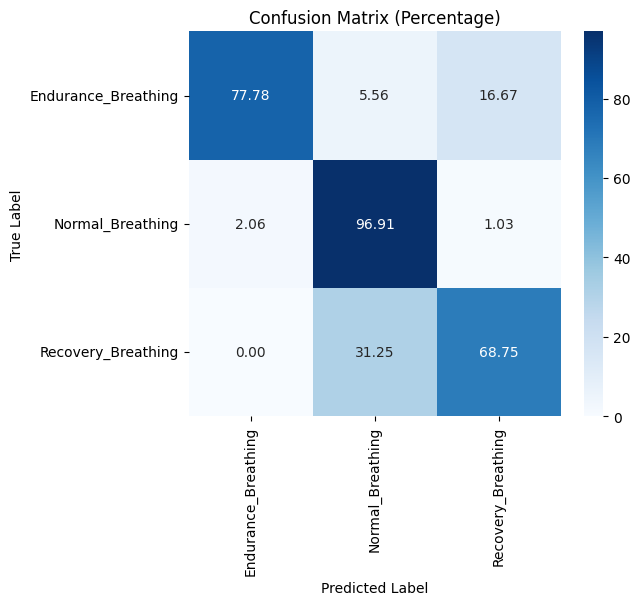

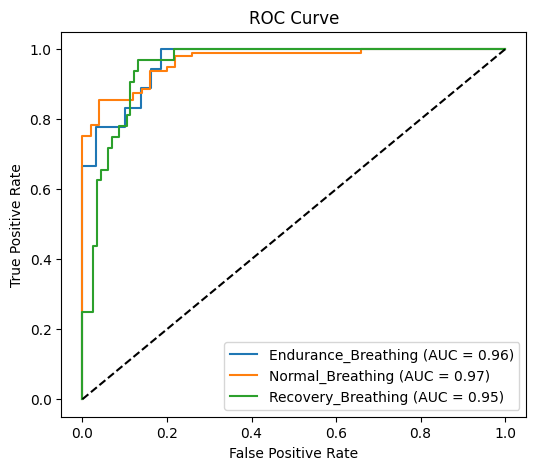

Model training completed and saved.


In [6]:
#LSTM MODEL
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc,precision_recall_fscore_support
import joblib
from tensorflow.keras.callbacks import EarlyStopping

# Load dataset
file_path = "C:\\Users\\ADWIN ADI\\Downloads\\breathing.csv files\\MainData_NaN_Outliner_Removed (1).csv"
df = pd.read_csv(file_path)

# Print dataset info
print("Dataset Shape:", df.shape)
print("First Few Rows:\n", df.head())

# Drop NaN values
df.dropna(inplace=True)
print("After Dropping NaN - Shape:", df.shape)

# Ensure dataset is not empty after dropping NaN values
if df.empty:
    raise ValueError("Dataset is empty after dropping NaN values. Check the CSV file!")

# Select features (all columns except the last one) and target (last column)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
joblib.dump(label_encoder, "/mnt/data/label_encoder.pkl")

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.nan_to_num(X_scaled)
joblib.dump(scaler, "/mnt/data/scaler.pkl")

# Verify no NaN values exist
if np.isnan(X_scaled).any() or np.isnan(y_encoded).any():
    raise ValueError("NaN values detected in dataset after preprocessing!")

# Segment data into 10-second windows at 15 Hz (150 samples per segment)
segment_size = 150
num_segments = len(X_scaled) // segment_size
if num_segments == 0:
    raise ValueError(f"Not enough samples for segmentation! Required: {segment_size}, Found: {len(X_scaled)}")

X_segmented = np.array([X_scaled[i * segment_size:(i + 1) * segment_size] for i in range(num_segments)])

def majority_label(labels):
    return np.bincount(labels).argmax()

y_segmented = np.array([majority_label(y_encoded[i * segment_size:(i + 1) * segment_size]) for i in range(num_segments)])

# One-hot encode labels
ohe = OneHotEncoder(sparse_output=False)
y_segmented_ohe = ohe.fit_transform(y_segmented.reshape(-1, 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_segmented, y_segmented_ohe, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, callbacks=[early_stopping])

# Save trained model
model.save("/mnt/data/breathing_pattern_model.h5")

# Predict test labels
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Confusion matrix (percentage format)
cm = confusion_matrix(y_test_labels, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing'], 
            yticklabels=['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# ROC Curve
plt.figure(figsize=(6, 5))
class_labels = ['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing']

for i in range(y_train.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Performance Table
precision, recall, f1, _ = precision_recall_fscore_support(y_test_labels, y_pred, labels=[0, 1, 2])
accuracy = np.mean(y_test_labels == y_pred)
loss = model.evaluate(X_test, y_test, verbose=0)[0]

performance_table = pd.DataFrame({
    "Metric": ["Loss", "Accuracy", "F1 Score"],
    "Endurance Breathing": [loss, accuracy, f1[0]],
    "Normal Breathing": [loss, accuracy, f1[1]],
    "Recovery Breathing": [loss, accuracy, f1[2]]
})

print("Performance Metrics:")
print(performance_table)

print("Model training completed and saved.")


Dataset Shape: (129898, 7)
First Few Rows:
    Sensor1_Temp  Sensor1_Pressure  Sensor1_Humidity  Sensor2_Temp  \
0         33.97          909.5364             78.81         33.96   
1         33.96          909.5364             78.81         33.95   
2         33.95          909.5324             78.99         33.94   
3         33.95          909.5289             79.12         33.94   
4         33.95          909.5289             79.18         33.94   

   Sensor2_Pressure  Sensor2_Humidity Label  
0          909.4451             87.90     N  
1          909.4553             87.90     N  
2          909.4709             87.99     N  
3          909.4604             88.01     N  
4          909.4604             88.01     N  
After Dropping NaN - Shape: (109971, 7)
Epoch 1/50
19/19 [==============================] - 11s 255ms/step - loss: 1.0746 - accuracy: 0.4420 - val_loss: 0.8263 - val_accuracy: 0.7143
Epoch 2/50
19/19 [==============================] - 3s 171ms/step - loss: 0.7925 -

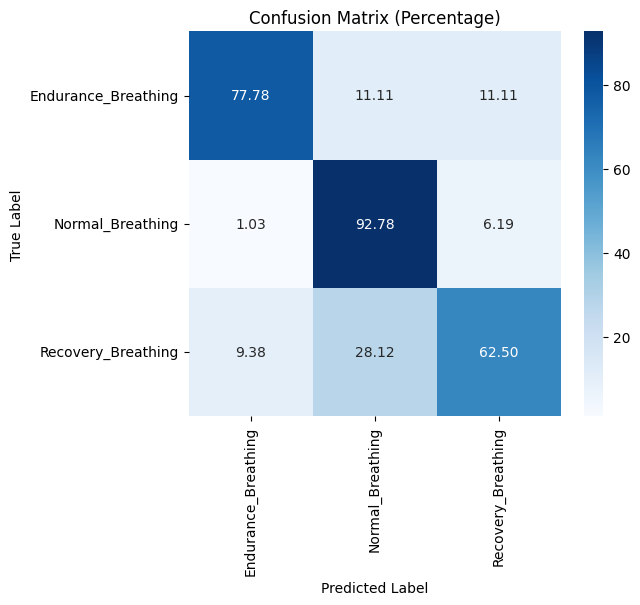

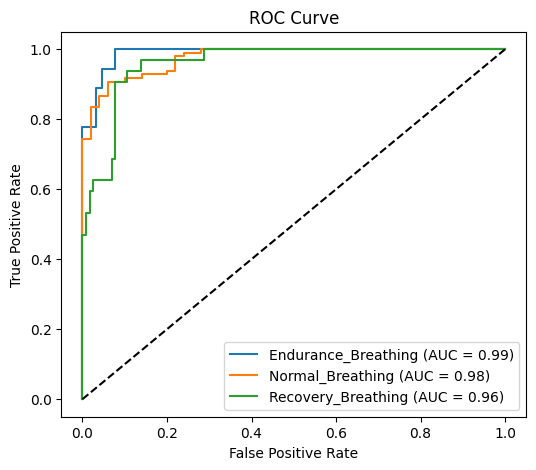

Model training completed and saved.


In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc,precision_recall_fscore_support
import joblib

# Load dataset
file_path ="C:\\Users\\ADWIN ADI\\Downloads\\breathing.csv files\\MainData_NaN_Outliner_Removed (1).csv"
df = pd.read_csv(file_path)

# Print dataset info
print("Dataset Shape:", df.shape)
print("First Few Rows:\n", df.head())

# Drop NaN values
df.dropna(inplace=True)
print("After Dropping NaN - Shape:", df.shape)

# Ensure dataset is not empty after dropping NaN values
if df.empty:
    raise ValueError("Dataset is empty after dropping NaN values. Check the CSV file!")

# Select features (all columns except the last one) and target (last column)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
joblib.dump(label_encoder, "/mnt/data/label_encoder.pkl")

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.nan_to_num(X_scaled)
joblib.dump(scaler, "/mnt/data/scaler.pkl")

# Verify no NaN values exist
if np.isnan(X_scaled).any() or np.isnan(y_encoded).any():
    raise ValueError("NaN values detected in dataset after preprocessing!")

# Segment data into 10-second windows at 15 Hz (150 samples per segment)
segment_size = 150
num_segments = len(X_scaled) // segment_size
if num_segments == 0:
    raise ValueError(f"Not enough samples for segmentation! Required: {segment_size}, Found: {len(X_scaled)}")

X_segmented = np.array([X_scaled[i * segment_size:(i + 1) * segment_size] for i in range(num_segments)])

def majority_label(labels):
    return np.bincount(labels).argmax()

y_segmented = np.array([majority_label(y_encoded[i * segment_size:(i + 1) * segment_size]) for i in range(num_segments)])

# One-hot encode labels
ohe = OneHotEncoder(sparse_output=False)
y_segmented_ohe = ohe.fit_transform(y_segmented.reshape(-1, 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_segmented, y_segmented_ohe, test_size=0.2, random_state=42)

# Build GRU model
model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    GRU(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32 , callbacks=[early_stopping])

# Save trained model
model.save("/mnt/data/breathing_pattern_model.h5")

# Predict test labels
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Confusion matrix (percentage format)
cm = confusion_matrix(y_test_labels, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing'], 
            yticklabels=['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# ROC Curve
plt.figure(figsize=(6, 5))
class_labels = ['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing']

for i in range(y_train.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Performance Table
precision, recall, f1, _ = precision_recall_fscore_support(y_test_labels, y_pred, labels=[0, 1, 2])
accuracy = np.mean(y_test_labels == y_pred)
loss = model.evaluate(X_test, y_test, verbose=0)[0]

performance_table = pd.DataFrame({
    "Metric": ["Loss", "Accuracy", "F1 Score"],
    "Endurance Breathing": [loss, accuracy, f1[0]],
    "Normal Breathing": [loss, accuracy, f1[1]],
    "Recovery Breathing": [loss, accuracy, f1[2]]
})

print("Performance Metrics:")
print(performance_table)

print("Model training completed and saved.")
